# Farmland & Crops Image Crop

## Import Package


In [1]:
import os
import random
import time
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Const & Inputs

Here are all of the parameters to change for the run.


In [3]:

# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."
# path = "/content/drive/MyDrive/Colab Notebooks/aidea-farmland-crops-autumn"

# Folder of the training data
training_folder = 'D:/Dataset/aidea-farmland-crops-autumn/train'

# Folder of the public data
public_folder = 'D:/Dataset/aidea-farmland-crops-autumn/public'

# Number of classes in the dataset
num_classes = 33

# Image size for model
image_size = 224

# options: (subset, fullset)
train_mode = 'subset'

# Whether to reprocess the data
reprocess = False

# Get the shape of the input layer
input_shape = (image_size, image_size, 3)

In [4]:
tw = ["非作物", "甘藍", "甘藷", "檳榔", "芒果", "竹筍", "茶", "蔥", "木瓜", "太陽麻", "紅豆", "毛豆", "芋", "葡萄", "青花菜", "茭白筍", "絲瓜",
      "荔枝", "龍眼", "韭菜", "狼尾草", "檸檬", "萵苣", "花椰菜", "梨", "田菁", "番荔枝", "百香果", "蓮霧", "結球白菜", "溫網室", "洋蔥", "蘆筍"]
en = ["others", "kale", "sweetpotato", "betel", "mango", "bambooshoots", "tea", "greenonion", "papaya", "sunhemp", "redbeans", "soybeans", "taro", "grape", "broccoli", "waterbamboo", "loofah", "litchi",
      "longan", "chinesechives", "pennisetum", "lemon", "lettuce", "cauliflower", "pear", "sesbania", "custardapple", "passionfruit", "roseapple", "chinesecabbage", "greenhouse", "onion", "asparagus"]
classes_name = pd.DataFrame({"tw": tw, "en": en}).sort_values(by=['en'], ignore_index=True)


## Helper Functions

Before we write the code for adjusting the models, lets define a few helper functions.


In [33]:
import cv2

def crop_around_center(image, width, height, image_center):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point

    Arguments:
    ----------
        image_center: (x, y), default=None
            
    Returns:
    --------
        image_rgb: 3d-array
            image vector converted to rgb format.   
            
    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """

    image_size = [image.shape[1], image.shape[0]]
    
    # 為提供中心座標的時候，預設為圖片正中心
    if(image_center is None):
        image_center = [int(image_size[0] * 0.5), int(image_size[1] * 0.5)]

    # 如果輸出寬度大於圖片寬度，則將輸出寬度設為圖片寬度
    if(width > image_size[0]):
        width = image_size[0]

    # 如果從 x 座標算起，輸出寬度會超出圖片邊界，則將 x 座標往左或往右推移
    x_boundary = (image_center[0] - int(width * 0.5), image_center[0] + int(width * 0.5))
    
    # 超出左邊界
    if(x_boundary[0] < 0):
        # print('beyond the left border')
        image_center[0] = image_center[0] + abs(x_boundary[0])
        
    # 超出右邊界
    if(x_boundary[1] > image_size[0]):
        # print('beyond the right border')
        image_center[0] = image_center[0] - abs(x_boundary[1] - image_size[0])
        
    # 如果輸出高度大於圖片高度，則將輸出高度設為圖片高度
    if(height > image_size[1]):
        height = image_size[1]
        
    # 如果從 y 座標算起，輸出高度會超出圖片邊界，則將 y 座標往上或往下推移
    y_boundary = (image_center[1] - int(height * 0.5), image_center[1] + int(height * 0.5))
    
    # 超出上邊界
    if(y_boundary[0] < 0):
        # print('beyond the upper bound')
        image_center[1] = image_center[1] + abs(y_boundary[0])
        
    # 超出下邊界
    if(y_boundary[1] > image_size[1]):
        # print('beyond the lower boundary')
        image_center[1] = image_center[1] - abs(y_boundary[1] - image_size[1])
        
    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)
    return image[y1:y2, x1:x2]

def load_image_and_resize(path, new_size=224, resize_method="resize", padding_method="wrap", crop_ratio=0.5, crop_center=None, rotate=False):
    """Use CV2 to read image, and resize the image to make the aspect ratio.

    Arguments:
    ----------
        path: string, default=None
            image path. 

        new_size: number, default=500
            desired image size.

        resize_method: 'resize' or 'padding', default='resize'
            resize: only resize.
            padding: padding and resize.

        padding_method: 'wrap' or 'constant'
            wrap: take mirrored pixel padding.
            constant: border padding to a fixed value.
        
        crop_ratio: number, default=0.5
            The ratio of the clipping box to the target size.

    Returns:
    --------
        image_rgb: 3d-array
            image vector converted to rgb format.
    """
    image = cv2.imread(path)
    height, width, channel = image.shape

    if resize_method == "padding":
        # resize by ratio
        ratio = new_size / max(height, width)
        new_height, new_width = int(ratio * height), int(ratio * width)
        image = cv2.resize(image, (new_width, new_height))

        # calculate boundaries
        top, bottom = (new_size-new_height) // 2, (new_size-new_height) // 2
        if top + bottom + height < new_size:
            bottom += 1
        left, right = (new_size-new_width) // 2, (new_size-new_width) // 2
        if left + right + width < new_size:
            right += 1

        # padding
        if padding_method == "wrap":
            image = cv2.copyMakeBorder(
                image, top, bottom, left, right, cv2.BORDER_WRAP)
        elif padding_method == "constant":
            image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    elif resize_method == "crop":
        crop_window = min(height, width) * crop_ratio
        crop_center = [width / 2 + crop_center[0], height / 2 + crop_center[1]]
        image = crop_around_center(image, crop_window, crop_window, crop_center)
        image = cv2.resize(image, (new_size, new_size), interpolation=cv2.INTER_CUBIC)
    elif resize_method == "resize":
        image = cv2.resize(image, (new_size, new_size), interpolation=cv2.INTER_CUBIC)
    if(rotate):
        image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### Playground


In [8]:
fullset = pd.read_csv(F'{path}/data/train_tag_loc_coor_describe_elevation.csv')
fullset[fullset['file'].eq('00b8e10a-04c6-42e6-8cbe-1db2920cc157.jpg')]

,file,label,make,model,taken_datetime,taken_month,taken_year,taken_hour,target_fid,target_x,target_y,county_name,town_name,town_x,town_y,town_z,shape,width,height,angle
6,00b8e10a-04c6-42e6-8cbe-1db2920cc157.jpg,asparagus,NaN,NaN,NaN,NaN,NaN,NaN,6,0,0,雲林縣,褒忠鄉,120.311607,23.716225,11,"(2448, 3264)",2448,3264,270.0


In [9]:
fullset[fullset['file'].eq('00c5815c-ffc2-4f50-89ec-bc9fe9416be3.jpg')]

,file,label,make,model,taken_datetime,taken_month,taken_year,taken_hour,target_fid,target_x,target_y,county_name,town_name,town_x,town_y,town_z,shape,width,height,angle
7,00c5815c-ffc2-4f50-89ec-bc9fe9416be3.jpg,asparagus,Apple,iPhone XS Max,2019/10/25 09:51,10.0,2019.0,9.0,7,0,-102,彰化縣,二林鎮,120.404221,23.916302,19,"(1633, 1225)",1633,1225,270.0


In [44]:
sample = fullset[~fullset['target_x'].eq(0)].reset_index(drop=True)
randomidx = np.random.randint(0, len(sample), 8)
sample = sample.iloc[randomidx].reset_index(drop=True) 

可以觀察到官方的 x, y 設定似乎給反

item: 1
item: 2
超出左邊界
item: 3
item: 4
超出左邊界
item: 5
item: 6


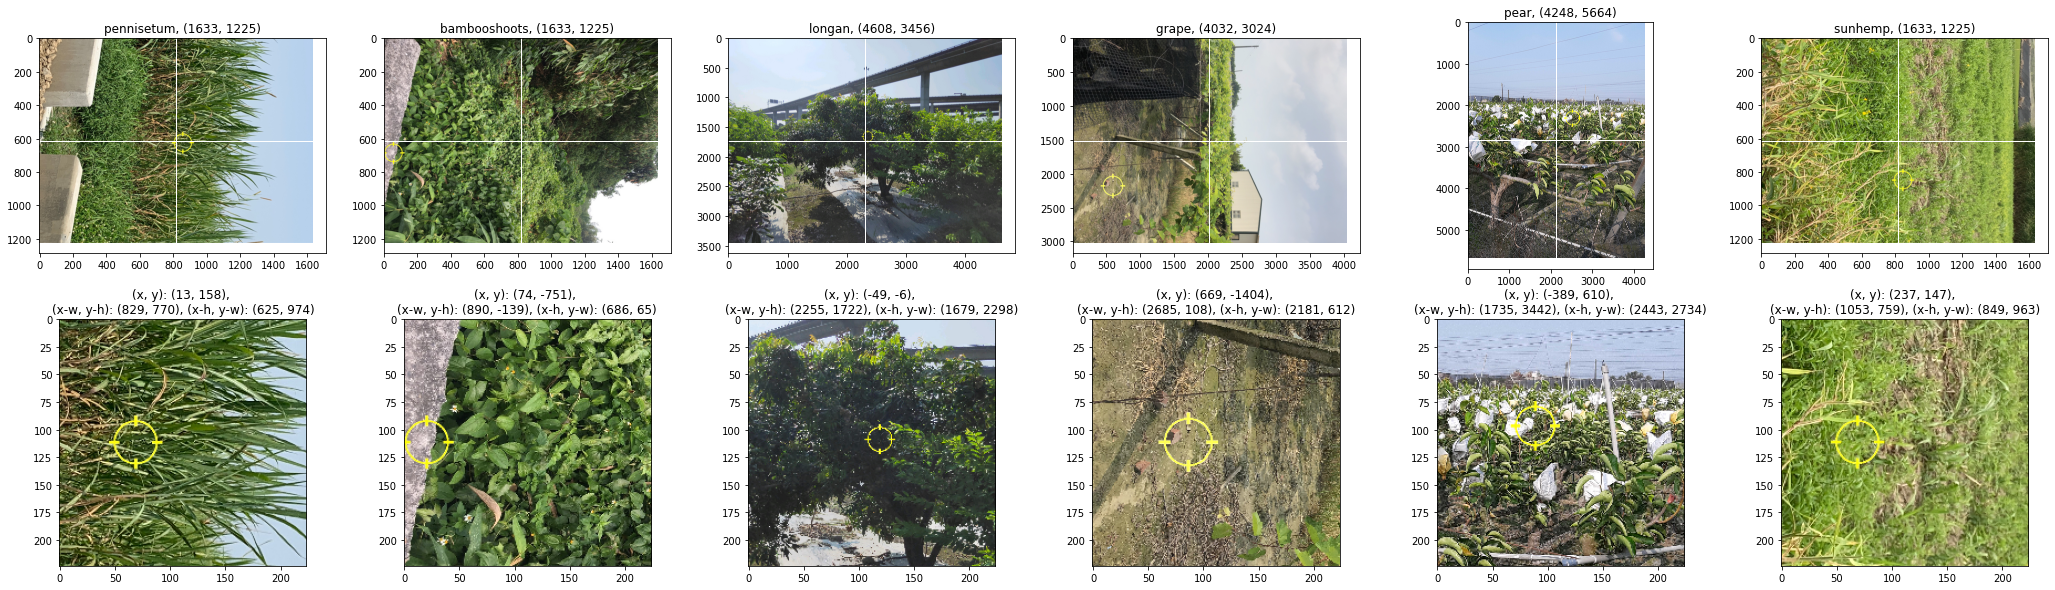

In [61]:
def row_based_idx(num_rows, num_cols, idx):
    return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

items = 6
variants = 1
plt.figure(figsize=(items * 6, variants * 10))
for item in range(items):
    print('item:', item+1)
    row = sample.iloc[item]
    # read original image
    image = cv2.imread(F'{training_folder}/{row["label"]}/{row["file"]}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot((variants + 1), items, row_based_idx((variants + 1), items, item * (variants + 1) + 1))
    plt.title("{}, {}".format(row["label"], row["shape"]))
    plt.imshow(image.astype("uint8"))
    plt.plot([0, image.shape[1]], [image.shape[0]/2, image.shape[0]/2], color="white", linewidth=1)
    plt.plot([image.shape[1]/2, image.shape[1]/2], [image.shape[0], 0], color="white", linewidth=1)
    # crop image
    crop = load_image_and_resize(
        path=F'{training_folder}/{row["label"]}/{row["file"]}', 
        resize_method="crop", crop_ratio=0.5, crop_center=(row["target_y"], row["target_x"]))
   
    xy = (row["target_x"], row["target_y"])
    xwyh = (row["target_x"]+row['width']//2, row["target_y"]+row['height']//2)
    xhyw = (row["target_x"]+row['height']//2, row["target_y"]+row['width']//2)
    ax = plt.subplot((variants + 1), items, row_based_idx((variants + 1), items, item * (variants + 1) + 2))
    plt.imshow(crop.astype("uint8"))
    plt.title("(x, y): {}, \n(x-w, y-h): {}, (x-h, y-w): {}".format(xy, xwyh, xhyw))